# Semeval 2025 Task 10

## Subtask 1: Entity Framing -- Multilingual

Given a news article and a list of mentions of named entities (NEs) in the article, assign for each such mention one or more roles using a predefined taxonomy of fine-grained roles covering three main type of roles: protagonists, antagonists, and innocent. This is a multi-label multi-class text-span classification task.

### Using multilingual embeddings, and ML models

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from matplotlib import pyplot as plt
import seaborn as sns
import os

In [3]:
data = []
ignore_folders = ['.DS_Store']

base_dir_documents = '../data/semeval_data/raw-documents'

for language_folder in os.listdir(base_dir_documents):

    if language_folder in ignore_folders:
        continue

    language_path = os.path.join(base_dir_documents, language_folder)
    if os.path.isdir(language_path):
        for root, _, files in os.walk(language_path):
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)

                    article_id = file
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()

                    data.append({
                        'language': language_folder,
                        'article_id': article_id,
                        'content': content
                    })

documents_df = pd.DataFrame(data)

In [4]:
documents_df.shape

(726, 3)

In [5]:
documents_df.sample(5)

,language,article_id,content
62,PT,PT_24.txt,Rússia 'tem sido bem-sucedida' no combate à he...
610,EN,EN_UA_102655.txt,BIOWARFARE ON AMERICANS: RFK Jr. says CIA was ...
300,BG,BG_1258.txt,"Нов доклад с ужасяваща новина за Европа, скоро..."
51,PT,PT_177.txt,Onda de calor extremo: o que fazer para evitar...
376,BG,A9_BG_8333.txt,Украйна в паника от създаването на «Искандер-1...


In [6]:
documents_df['article_id'].unique

<bound method Series.unique of 0             PT_53.txt
1             PT_47.txt
2             PT_90.txt
3             PT_84.txt
4            PT_166.txt
             ...       
721    EN_CC_100076.txt
722    EN_UA_103251.txt
723    EN_UA_002991.txt
724    EN_UA_008072.txt
725    EN_UA_015962.txt
Name: article_id, Length: 726, dtype: object>

In [7]:
base_dir_labels = '../data/semeval_data/labels'

raw_annotation_data = []

for language_folder in os.listdir(base_dir_labels):

    if language_folder in ignore_folders:
        continue

    language_path = os.path.join(base_dir_labels, language_folder)
    if os.path.isdir(language_path):
        for root, _, files in os.walk(language_path):
            label_file = 'subtask-1-annotations.txt'
            file_path = os.path.join(root, label_file)
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    parts = line.strip().split('\t')
                    article_id = parts[0]
                    entity_mention = parts[1]
                    start_offset = int(parts[2])
                    end_offset = int(parts[3])
                    main_role = parts[4]

                    sub_roles = parts[5:]
                    raw_annotation_data.append({
                        "article_id": article_id,
                        "entity_mention": entity_mention,
                        "start_offset": start_offset,
                        "end_offset": end_offset,
                        "main_role": main_role,
                        "sub_roles": sub_roles,
                    })

annotations_df = pd.DataFrame(raw_annotation_data)

In [8]:
annotations_df.head()

,article_id,entity_mention,start_offset,end_offset,main_role,sub_roles
0,PT_161.txt,Portugal,377,384,Innocent,[Victim]
1,PT_161.txt,França,1072,1077,Innocent,[Victim]
2,PT_161.txt,IPMA,2158,2161,Protagonist,[Guardian]
3,PT_13.txt,Ucrânia,184,190,Innocent,[Victim]
4,PT_196.txt,Engajamundo,421,431,Protagonist,[Rebel]


In [9]:
annotations_df.shape

(2535, 6)

In [10]:
dataset = pd.merge(documents_df, annotations_df, on='article_id')
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles
0,PT,PT_53.txt,Mais de 1600 Cientistas Negam a Emergência Cli...,Ivar Giaever,937,948,Protagonist,[Guardian]
1,PT,PT_53.txt,Mais de 1600 Cientistas Negam a Emergência Cli...,John F. Clauser,952,966,Protagonist,[Guardian]
2,PT,PT_47.txt,Zelensky admite a inevitabilidade da retirada ...,Ucrânia,857,863,Innocent,[Forgotten]
3,PT,PT_84.txt,Zelensky planeia segunda cimeira de paz em nov...,Volodymyr Zelensky,113,130,Protagonist,[Peacemaker]
4,PT,PT_84.txt,Zelensky planeia segunda cimeira de paz em nov...,Rússia,372,377,Antagonist,[Foreign Adversary]


In [11]:
def extract_article_id(filename):
    number_part = filename.split('_')[-1].split('.')[0]
    return number_part

print(extract_article_id('EN_UA_103861.txt'))

103861


In [12]:
dataset['article_id'] = dataset['article_id'].apply(extract_article_id)

In [13]:
print(dataset.iloc[6].content)

Mais duas carcaças de golfinhos são encontradas no Lago Tefé, no Amazonas

A ação de acompanhamento de emergência e possível retirada dos botos do Lago Tefé, no Amazonas, encontrou duas carcaças destes animais, informou hoje (2) o Instituto de Desenvolvimento Sustentável Mamirauá. A mobilização, realizada no fim de semana, ocorreu após a morte de mais de 100 mamíferos aquáticos, como o boto vermelho e o tucuxi, que viviam no local.

No sábado (30), o Instituto Chico Mendes de Conservação da Biodiversidade (ICMBio) enviou equipas de veterinários e servidores do Centro de Mamíferos Aquáticos (CMA) e da Divisão de Emergência Ambiental, para apurar as causas da mortandade extrema destes mamíferos. Além da seca, a hipótese é que o calor esteja a provocar as mortes de peixes e mamíferos na região.

A mobilização envolve organizações parceiras, como o Mamirauá, com ações de monitorização dos animais ainda vivos, busca e recolha de carcaças, recolha de amostras da água para análises de doenças

In [14]:
print(dataset.iloc[6].entity_mention)

Fleischmann


In [15]:
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles
0,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,Ivar Giaever,937,948,Protagonist,[Guardian]
1,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,John F. Clauser,952,966,Protagonist,[Guardian]
2,PT,47,Zelensky admite a inevitabilidade da retirada ...,Ucrânia,857,863,Innocent,[Forgotten]
3,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Volodymyr Zelensky,113,130,Protagonist,[Peacemaker]
4,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Rússia,372,377,Antagonist,[Foreign Adversary]


In [16]:
dataset.shape

(2535, 8)

In [17]:
dataset['main_role'].explode().value_counts()

main_role
Antagonist     1234
Protagonist     737
Innocent        564
Name: count, dtype: int64

In [18]:
dataset['sub_roles'].explode().value_counts()

sub_roles
Victim               478
Foreign Adversary    363
Guardian             285
Virtuous             218
Instigator           207
Peacemaker           163
Incompetent          144
Tyrant               127
Conspirator          120
Deceiver             112
Terrorist            101
Corrupt               90
Rebel                 60
Saboteur              52
Exploited             49
Underdog              43
Traitor               31
Scapegoat             26
Forgotten             24
Bigot                 23
Martyr                20
Spy                   16
Name: count, dtype: int64

In [19]:
dataset.isnull().sum()

language          0
article_id        0
content           0
entity_mention    0
start_offset      0
end_offset        0
main_role         0
sub_roles         0
dtype: int64

In [20]:
def get_context(row, window=50):
    content = row['content']
    start = int(row['start_offset'])
    end = int(row['end_offset'])

    words = content.split()

    pre_entity_text = content[:start].split()
    post_entity_text = content[end + 1:].split()

    # Get context words before and after
    context_before = " ".join(pre_entity_text[-window:])
    context_after = " ".join(post_entity_text[:window])

    return context_before, context_after

dataset['context_before'], dataset['context_after'] = zip(*dataset.apply(get_context, axis=1))

In [21]:
example_context = "Moscow: Russia will ask the UN Security Council for an investigation"
entity_mention = "Russia"
start_offset = 8
end_offset = 13

example_df = pd.DataFrame({
    'content': [example_context],
    'entity_mention': [entity_mention],
    'start_offset': [start_offset],
    'end_offset': [end_offset]
})

example_df

,content,entity_mention,start_offset,end_offset
0,Moscow: Russia will ask the UN Security Counci...,Russia,8,13


In [22]:
get_context(example_df.iloc[0])

('Moscow:', 'will ask the UN Security Council for an investigation')

In [23]:
dataset['entity_context'] = dataset['context_before'] + " " + dataset['entity_mention'] + " " + dataset['context_after']

In [24]:
dataset.drop(columns=['context_before', 'context_after'], inplace=True)
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,Ivar Giaever,937,948,Protagonist,[Guardian],"causas”, disse o grupo de cientistas. Defendem..."
1,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,John F. Clauser,952,966,Protagonist,[Guardian],de cientistas. Defendem que este gás é “essenc...
2,PT,47,Zelensky admite a inevitabilidade da retirada ...,Ucrânia,857,863,Innocent,[Forgotten],"Washington Post. ""Se não houver apoio dos Esta..."
3,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Volodymyr Zelensky,113,130,Protagonist,[Peacemaker],Zelensky planeia segunda cimeira de paz em nov...
4,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Rússia,372,377,Antagonist,[Foreign Adversary],e diz que Rússia deve participar O presidente ...


In [25]:
dataset.head()

,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context
0,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,Ivar Giaever,937,948,Protagonist,[Guardian],"causas”, disse o grupo de cientistas. Defendem..."
1,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,John F. Clauser,952,966,Protagonist,[Guardian],de cientistas. Defendem que este gás é “essenc...
2,PT,47,Zelensky admite a inevitabilidade da retirada ...,Ucrânia,857,863,Innocent,[Forgotten],"Washington Post. ""Se não houver apoio dos Esta..."
3,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Volodymyr Zelensky,113,130,Protagonist,[Peacemaker],Zelensky planeia segunda cimeira de paz em nov...
4,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Rússia,372,377,Antagonist,[Foreign Adversary],e diz que Rússia deve participar O presidente ...


In [26]:
!python3 -m spacy download xx_ent_wiki_sm
!python3 -m spacy download en_core_web_sm
!python3 -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.4 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 9.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 10.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [27]:
language_model_map = {
    "BG": "xx_ent_wiki_sm",
    "EN": "en_core_web_sm",
    "HI": "xx_ent_wiki_sm",
    "PT": "pt_core_news_sm",
}

In [28]:
!pip3 install emoji

In [29]:
import spacy
import re
import emoji

nlp_models = {lang: spacy.load(model) for lang, model in language_model_map.items()}

def clean_article(article_text, language_code, entity_mention):
    nlp = nlp_models.get(language_code, nlp_models["EN"])

    article_text = re.sub(
        r'(http\S+|www\S+|https\S+|[a-zA-Z0-9.-]+\.com|'
        r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+|@[A-Za-z0-9_]+)',
        '',
        article_text
    )

    doc = nlp(article_text)

    cleaned_tokens = []
    important_entity_types = ["PERSON", "ORG", "GPE"]

    for token in doc:
        if token.is_space or emoji.is_emoji(token.text):
            continue

        if token.text.lower() == entity_mention.lower():
            cleaned_tokens.append(f"[ENTITY_START] {entity_mention} [ENTITY_END] ")
        else:
            cleaned_tokens.append(token.text.lower() + token.whitespace_)

    return "".join(cleaned_tokens).strip()

dataset["entity_context"] = dataset.apply(
    lambda row: clean_article(row["entity_context"], row["language"], row["entity_mention"]),
    axis=1
)

In [30]:
print(dataset.iloc[6].entity_context)

no entanto, ontem, às 16h, subiu para os 37,8°c e estamos muito alerta. ainda não há um avanço maior para saber a causa das mortes, mas a temperatura continua a ser o principal candidato da causa da mortalidade, disse à agência brasil o membro do instituto mamirauá, ayan [ENTITY_START] Fleischmann [ENTITY_END] . segundo [ENTITY_START] Fleischmann [ENTITY_END] , ainda não há uma atualização sobre o resgate dos animais ainda vivos que estão no lago. na sexta-feira (29), o mamirauá lançou um alerta à população que vive nas imediações do lago tefé para evitar o contacto com as águas do lago e também o uso recreativo. em entrevista


In [31]:
from sklearn.preprocessing import LabelEncoder

le_main_role = LabelEncoder()
dataset['main_role_encoded'] = le_main_role.fit_transform(dataset['main_role'])

In [32]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_sub_role = MultiLabelBinarizer()
dataset.loc[:, 'sub_roles_encoded'] = list(mlb_sub_role.fit_transform(dataset['sub_roles']))

print(dataset.shape)
dataset.head()

(2535, 11)


,language,article_id,content,entity_mention,start_offset,end_offset,main_role,sub_roles,entity_context,main_role_encoded,sub_roles_encoded
0,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,Ivar Giaever,937,948,Protagonist,[Guardian],"causas”, disse o grupo de cientistas. defendem...",2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,PT,53,Mais de 1600 Cientistas Negam a Emergência Cli...,John F. Clauser,952,966,Protagonist,[Guardian],de cientistas. defendem que este gás é “essenc...,2,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,PT,47,Zelensky admite a inevitabilidade da retirada ...,Ucrânia,857,863,Innocent,[Forgotten],"washington post. ""se não houver apoio dos esta...",1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Volodymyr Zelensky,113,130,Protagonist,[Peacemaker],zelensky planeia segunda cimeira de paz em nov...,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
4,PT,84,Zelensky planeia segunda cimeira de paz em nov...,Rússia,372,377,Antagonist,[Foreign Adversary],e diz que [ENTITY_START] Rússia [ENTITY_END] d...,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [64]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/LaBSE')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/models/Dense.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the 

In [34]:
texts = [
    "This is a news article about politics.",  # English
    "यह राजनीति के बारे में एक समाचार लेख है।",  # Hindi
    "Este é um artigo de notícias sobre política.",  # Portuguese
    "Това е новинарска статия за политика.",  # Bulgarian
    "The sun rises in the east."  # Unrelated English sentence
]

In [35]:
embeddings = model.encode(texts)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)

print("Cosine Similarity Matrix:")
print(cos_sim_matrix)

Cosine Similarity Matrix:
[[1.         0.8829176  0.9265815  0.8651781  0.19801825]
 [0.8829176  1.0000002  0.96578115 0.89237857 0.23692542]
 [0.9265815  0.96578115 1.0000002  0.9107212  0.21260464]
 [0.8651781  0.89237857 0.9107212  1.0000002  0.18266794]
 [0.19801825 0.23692542 0.21260464 0.18266794 1.        ]]


In [37]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_temp = train_test_split(
    dataset,
    train_size=0.85,
    shuffle=True,
    stratify=dataset['main_role_encoded']
)

dataset_val, dataset_test = train_test_split(
    dataset_temp,
    train_size=0.5,
    shuffle=True,
    stratify=dataset_temp['main_role_encoded']
)

In [38]:
def get_embeddings_multilingual(dataset):
    embeddings = []
    for index, row in dataset.iterrows():
        content = row['entity_context']
        embedding = model.encode(content)
        combined_embedding = np.concatenate([embedding])
        embeddings.append(combined_embedding)
    embeddings_array = np.array(embeddings)
    return embeddings_array

In [39]:
def prepare_data(train_data, val_data):
    train_embeddings = get_embeddings_multilingual(train_data)
    val_embeddings = get_embeddings_multilingual(val_data)

    return train_embeddings, val_embeddings

In [40]:
train_embeddings, val_embeddings = prepare_data(dataset_train, dataset_val)

In [41]:
y_train_main_encoded = np.array(dataset_train['main_role_encoded'].tolist())
y_val_main_encoded = np.array(dataset_val['main_role_encoded'].tolist())

In [42]:
y_train_sub_encoded = np.array(dataset_train['sub_roles_encoded'].tolist())
y_val_sub_encoded = np.array(dataset_val['sub_roles_encoded'].tolist())

In [43]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix

def get_classification_report(y_true, y_pred):
  # Ignore warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    return conf_matrix

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def evaluate_model(model, x, y_true):
  y_pred = model.predict(x)
  classification_report_df = get_classification_report(y_true, y_pred)
  print(classification_report_df)
  print('\n')
  conf = plot_confusion_matrix(y_true, y_pred)
  return conf

def get_cross_val_score(model, x, y, scoring='f1_macro', splits=3):
  cv = StratifiedKFold(n_splits=splits, shuffle=True)
  cross_val_scores = cross_val_score(model, x, y, cv=cv, scoring=scoring)
  print(f"Cross-validation scores: {cross_val_scores}")
  print(f"Mean CV F1 Score: {cross_val_scores.mean()}")

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='cosine')
get_cross_val_score(knn_classifier, train_embeddings, y_train_main_encoded)

Cross-validation scores: [0.52934691 0.52436629 0.5147386 ]
Mean CV F1 Score: 0.5228172683272464


In [46]:
knn_classifier.fit(train_embeddings, y_train_main_encoded)

KNeighborsClassifier(metric='cosine', n_neighbors=3, weights='distance')

              precision    recall  f1-score     support
0              0.628866  0.663043  0.645503   92.000000
1              0.476190  0.465116  0.470588   43.000000
2              0.549020  0.509091  0.528302   55.000000
accuracy       0.573684  0.573684  0.573684    0.573684
macro avg      0.551359  0.545750  0.548131  190.000000
weighted avg   0.571200  0.573684  0.571990  190.000000




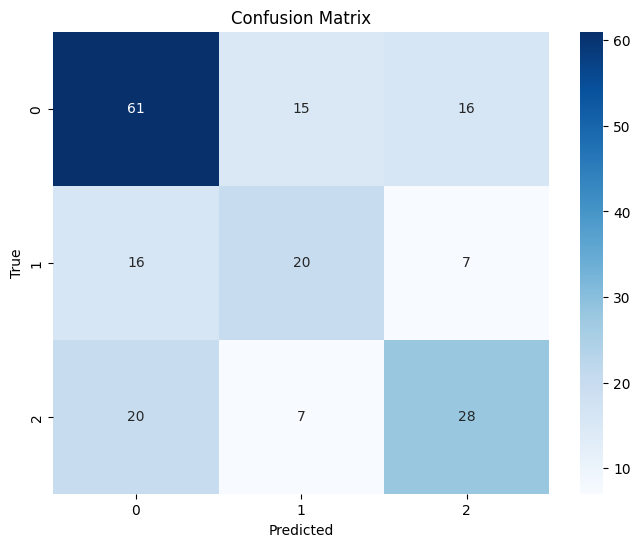

array([[61, 15, 16],
       [16, 20,  7],
       [20,  7, 28]])

In [47]:
evaluate_model(knn_classifier, val_embeddings, y_val_main_encoded)

In [48]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')

get_cross_val_score(logreg, train_embeddings, y_train_main_encoded)

Cross-validation scores: [0.55326269 0.53615225 0.52555892]
Mean CV F1 Score: 0.5383246210729511


In [49]:
logreg.fit(train_embeddings, y_train_main_encoded)

LogisticRegression(class_weight='balanced', max_iter=1000)

              precision    recall  f1-score     support
0              0.616279  0.576087  0.595506   92.000000
1              0.433962  0.534884  0.479167   43.000000
2              0.490196  0.454545  0.471698   55.000000
accuracy       0.531579  0.531579  0.531579    0.531579
macro avg      0.513479  0.521839  0.515457  190.000000
weighted avg   0.538520  0.531579  0.533337  190.000000




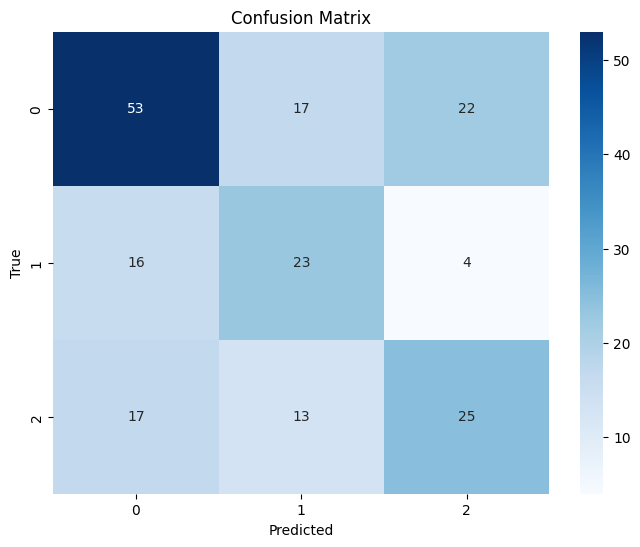

array([[53, 17, 22],
       [16, 23,  4],
       [17, 13, 25]])

In [50]:
evaluate_model(logreg, val_embeddings, y_val_main_encoded)

In [51]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=150)
get_cross_val_score(xgb_classifier, train_embeddings, y_train_main_encoded)

Cross-validation scores: [0.58101157 0.53279597 0.54586934]
Mean CV F1 Score: 0.5532256291345582


              precision    recall  f1-score     support
0              0.576642  0.858696  0.689956   92.000000
1              0.722222  0.302326  0.426230   43.000000
2              0.657143  0.418182  0.511111   55.000000
accuracy       0.605263  0.605263  0.605263    0.605263
macro avg      0.652002  0.526401  0.542432  190.000000
weighted avg   0.632892  0.605263  0.578500  190.000000




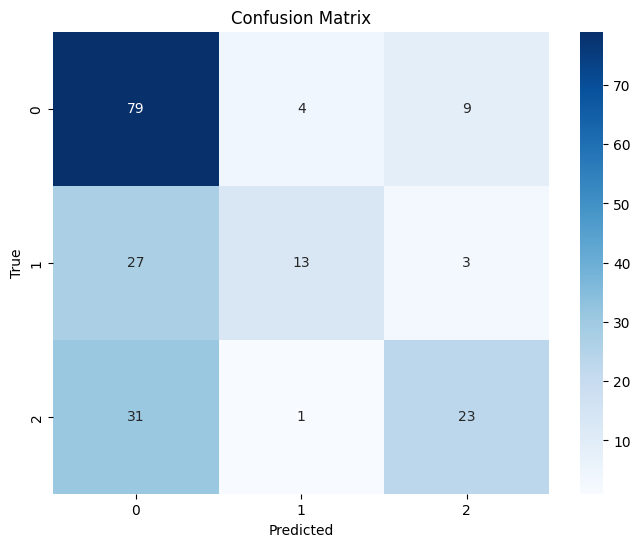

array([[79,  4,  9],
       [27, 13,  3],
       [31,  1, 23]])

In [52]:
xgb_classifier.fit(train_embeddings, y_train_main_encoded)
evaluate_model(xgb_classifier, val_embeddings, y_val_main_encoded)

In [53]:
from collections import Counter
Counter(y_train_main_encoded)

Counter({0: 1049, 2: 626, 1: 479})

In [54]:
from sklearn.utils import class_weight

classes = np.unique(y_train_main_encoded)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_main_encoded)
class_weights

array([0.68446139, 1.49895616, 1.14696486])

In [55]:
class_weights_dict = dict(zip(classes, class_weights))
class_weights_dict

{0: 0.684461391801716, 1: 1.498956158663883, 2: 1.1469648562300319}

In [56]:
sample_weights = np.array([class_weights_dict[label] for label in y_train_main_encoded])
sample_weights[:15]

array([0.68446139, 1.49895616, 1.14696486, 0.68446139, 1.14696486,
       1.49895616, 1.49895616, 0.68446139, 1.14696486, 0.68446139,
       0.68446139, 1.14696486, 1.49895616, 1.49895616, 1.14696486])

              precision    recall  f1-score  support
0              0.629630  0.739130  0.680000     92.0
1              0.500000  0.395349  0.441558     43.0
2              0.604167  0.527273  0.563107     55.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.577932  0.553917  0.561555    190.0
weighted avg   0.592922  0.600000  0.592199    190.0




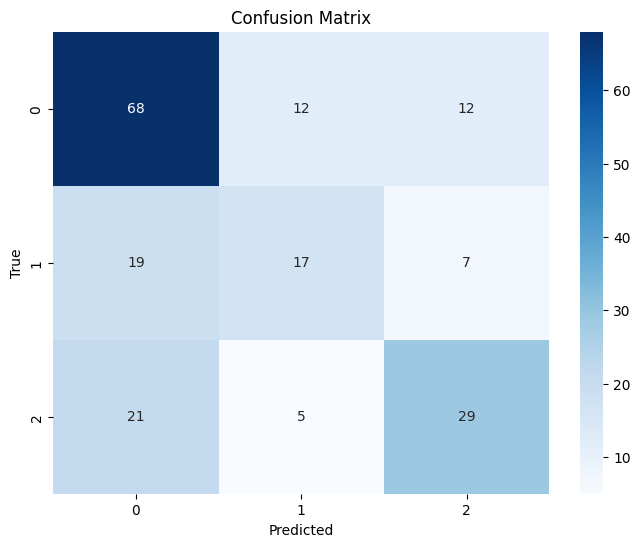

array([[68, 12, 12],
       [19, 17,  7],
       [21,  5, 29]])

In [57]:
import xgboost as xgb

xgb_weighted = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=150)
xgb_weighted.fit(train_embeddings, y_train_main_encoded, sample_weight=sample_weights)
evaluate_model(xgb_weighted, val_embeddings, y_val_main_encoded)

In [58]:
y_pred = xgb_weighted.predict(val_embeddings)
misclassified_indices = np.where(y_pred != y_val_main_encoded)[0]

In [59]:
misclassified_indices

array([  0,   2,   5,   9,  10,  12,  13,  16,  17,  18,  20,  21,  22,
        23,  24,  28,  30,  31,  32,  33,  36,  40,  41,  42,  43,  48,
        49,  50,  52,  54,  56,  57,  58,  59,  60,  61,  66,  70,  72,
        74,  75,  83,  85,  86,  89,  91,  94,  95,  96,  98, 106, 109,
       110, 114, 117, 120, 124, 126, 127, 131, 132, 133, 134, 140, 154,
       159, 163, 164, 167, 168, 170, 175, 179, 183, 186, 189])

In [60]:
true_labels_decoded = le_main_role.inverse_transform(y_val_main_encoded)
predicted_labels_decoded = le_main_role.inverse_transform(y_pred)

In [61]:
misclassified_articles = []

for idx in misclassified_indices:
    misclassified_articles.append({
        "article_id": idx,
        "true_label": true_labels_decoded[idx],
        "predicted_label": predicted_labels_decoded[idx],
        "context": dataset_val.iloc[idx]["entity_context"],
        "language": dataset_val.iloc[idx]["language"],
        "entity_mention": dataset_val.iloc[idx]["entity_mention"]
    })

misclassified_df = pd.DataFrame(misclassified_articles)

In [62]:
misclassified_df.head()

,article_id,true_label,predicted_label,context,language,entity_mention
0,0,Antagonist,Protagonist,e diz que [ENTITY_START] Rússia [ENTITY_END] d...,PT,Rússia
1,2,Antagonist,Protagonist,प्रधानमंत्री नरेंद्र मोदी की 8 और 9 जुलाई को अ...,HI,पश्चिमी देश
2,5,Antagonist,Innocent,тъй като предимството на неговата армия започв...,BG,Русия
3,9,Innocent,Protagonist,critic of congressional republican efforts to ...,EN,Ukraine
4,10,Innocent,Antagonist,ще трябва да отговаряте за [ENTITY_START] Сева...,BG,Севастопол


In [63]:
misclassified_df_en = misclassified_df[misclassified_df['language'] == "EN"]

for _, row in misclassified_df_en.iterrows():
    print(f"Entity Mention: {row['entity_mention']}")
    print(f"True Label: {row['true_label']} | Predicted Label: {row['predicted_label']}")
    print(f"Context: {row['context']}")
    print("=" * 80)

Entity Mention: Ukraine
True Label: Innocent | Predicted Label: Protagonist
Context: critic of congressional republican efforts to decouple us military aid for israel from a separate aid proposal for [ENTITY_START] Ukraine [ENTITY_END] as it defends itself against russia’s invasion. on tuesday he called on his gop colleagues in the upper chamber to cease efforts to pass a stand-alone israel aid bill. “israel and [ENTITY_START] Ukraine [ENTITY_END] are going through existential threats. we need to send aid to both, and my republican colleagues need to cut the crap,” fetterman wrote on x. “this isn’t a game,” he added.
Entity Mention: Adams
True Label: Antagonist | Predicted Label: Protagonist
Context: “global warming.” “we already know that a plant-powered diet is better for your physical and mental health, and i am living proof of that,” [ENTITY_START] Adams [ENTITY_END] declared. “but the reality is that thanks to this new inventory, we’re finding out it is better for the planet.” the

### Using Roberta to classify main roles

In [65]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [66]:
def tokenize_data(entity_contexts, max_length=512):
    encodings = tokenizer(entity_contexts, truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    return encodings

In [67]:
train_encodings = tokenize_data(dataset_train['entity_context'].tolist())
val_encodings = tokenize_data(dataset_val['entity_context'].tolist())

In [68]:
train_main_roles_truths = dataset_train['main_role_encoded'].tolist()

train_main_roles_truths[:5]

[0, 1, 2, 0, 2]

In [69]:
val_main_roles_truths = dataset_val['main_role_encoded'].tolist()

val_main_roles_truths[:5]

[0, 0, 0, 0, 0]

In [70]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss

model_config = {
    'batch_size': 16,
    'num_epochs': 5,
    'lr': 3e-5
}

In [ ]:
from transformers import XLMRobertaModel
import torch.nn as nn

class MultilingualRoleClassifier(nn.Module):
    def __init__(self, main_roles_len):
        super(MultilingualRoleClassifier, self).__init__()
        self.backbone = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.classifier = nn.Linear(self.backbone.config.hidden_size, main_roles_len)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        main_role_logits = self.classifier(pooled_output)
        return main_role_logits

In [ ]:
class EntityContextDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'main_role_labels': self.labels[idx]
        }

train_dataset = EntityContextDataset(
                              input_ids=train_encodings['input_ids'],
                              attention_mask=train_encodings['attention_mask'],
                             labels=train_main_roles_truths
                            )

val_dataset = EntityContextDataset(
                              input_ids=val_encodings['input_ids'],
                             attention_mask=val_encodings['attention_mask'],
                             labels=val_main_roles_truths
                            )

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=model_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=model_config['batch_size'])

In [ ]:
model = MultilingualRoleClassifier(main_roles_len=len(le_main_role.classes_))
optimizer = optim.AdamW(model.parameters(), lr=model_config['lr'])
criterion = CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_loader) * model_config['num_epochs']
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [ ]:
def freeze_roberta_layers(model, num_layers_to_freeze=2):
  assert hasattr(model, 'classifier'), "Model must have a classifier attribute"
  for i in range(num_layers_to_freeze):
    for param in model.backbone.encoder.layer[i].parameters():
      param.requires_grad = False

  for param in model.classifier.parameters():
    param.requires_grad = True

In [ ]:
freeze_roberta_layers(model)

In [ ]:
import torch

def train(train_loader, val_loader, model, optimizer, criterion, label, scheduler=None, num_epochs=10, patience=3, device='cuda'):
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch[label].to(device)
            logits = model(input_ids, attention_mask)

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch[label].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss (Avg): {avg_train_loss:.4f}, Val Loss (Avg): {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training after {epoch+1} epochs.")
            break

In [ ]:
train(train_loader=train_loader, val_loader=val_loader, model=model, optimizer=optimizer, criterion=criterion, label='main_role_labels', scheduler=scheduler)

In [ ]:
from sklearn.metrics import f1_score

def evaluate_transformer_model(
    model,
    val_loader,
    label_column,
    device='cuda',
    target_names=None
):
    model.eval()

    all_preds = []
    all_truths = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch[label_column].to(device)

            logits = model(input_ids, attention_mask)

            probs = torch.softmax(logits, dim=-1)
            model_preds = torch.argmax(probs, dim=-1)

            all_preds.extend(model_preds.cpu().numpy())
            all_truths.extend(labels.cpu().numpy())

    classification_rep = classification_report(all_truths, all_preds, target_names=target_names, zero_division=0)
    current_f1 = f1_score(all_truths, all_preds, average='macro')
    micro_f1 = f1_score(all_truths, all_preds, average='micro')

    print("Classification Report:")
    print(classification_rep)
    print(f"F1 Score (Macro Average): {current_f1}")
    print(f"F1 Score (Micro Average): {micro_f1}")

    accuracy = (np.array(all_preds) == np.array(all_truths)).mean()
    print(f"Accuracy: {accuracy}")

    conf_matrix = confusion_matrix(all_truths, all_preds)
    print("Confusion Matrix:")
    print(conf_matrix)

In [ ]:
evaluate_transformer_model(
    model,
    val_loader,
    label_column='main_role_labels',
    device='cuda',
    target_names=le_main_role.classes_
)

### Using Roberta to classify sub roles

In [ ]:
train_sub_roles_truth = dataset_train['sub_roles_encoded'].tolist()

train_sub_roles_truth[:5]

In [ ]:
val_sub_roles_truth = dataset_val['sub_roles_encoded'].tolist()

val_sub_roles_truth[:5]

In [ ]:
from transformers import XLMRobertaModel
import torch.nn as nn

class MultilingualSubRoleClassifier(nn.Module):
    def __init__(self, sub_roles_len):
        super(MultilingualSubRoleClassifier, self).__init__()
        self.backbone = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.classifier = nn.Linear(self.backbone.config.hidden_size, sub_roles_len)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        sub_roles_logits = self.classifier(pooled_output)
        return sub_roles_logits

In [ ]:
class SubRoleDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'sub_role_labels': self.labels[idx].astype(np.float32)
        }

train_dataset_sbr = SubRoleDataset(
                              input_ids=train_encodings['input_ids'],
                              attention_mask=train_encodings['attention_mask'],
                              labels=train_sub_roles_truth
                            )

val_dataset_sbr = SubRoleDataset(
                              input_ids=val_encodings['input_ids'],
                              attention_mask=val_encodings['attention_mask'],
                              labels=val_sub_roles_truth
                            )

In [ ]:
train_loader_sbr = DataLoader(train_dataset_sbr, batch_size=model_config['batch_size'], shuffle=True)
val_loader_sbr = DataLoader(val_dataset_sbr, batch_size=model_config['batch_size'], shuffle=False)

In [ ]:
sbr_model = MultilingualSubRoleClassifier(sub_roles_len=len(mlb_sub_role.classes_))

In [ ]:
from torch.nn import BCEWithLogitsLoss

model_config = {
    'batch_size': 16,
    'num_epochs': 10,
    'lr': 4e-5
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer_sbr = optim.AdamW(sbr_model.parameters(), lr=model_config['lr'])
criterion_sbr = BCEWithLogitsLoss()

sbr_model.to(device)

In [ ]:
from transformers import get_scheduler

num_training_steps = len(train_loader_sbr) * model_config['num_epochs']
scheduler_sbr = get_scheduler(
    "linear",
    optimizer=optimizer_sbr,
    num_warmup_steps=0.1 * num_training_steps,
    num_training_steps=num_training_steps,
)

In [ ]:
train(train_loader_sbr, val_loader_sbr, sbr_model, optimizer_sbr, criterion_sbr, 'sub_role_labels', scheduler=scheduler_sbr)

In [ ]:
from sklearn.metrics import f1_score

def evaluate_transformer_model(
    model,
    val_loader,
    label_column,
    thresholds=np.arange(0.1, 1.0, 0.1),
    device='cuda',
    target_names=None
):
    best_threshold = 0
    best_f1 = 0
    best_classification_report = None

    all_preds = []
    all_truths = []

    for threshold in thresholds:
        preds = []
        truths = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch[label_column].to(device)
                logits = model(input_ids, attention_mask)
                probs = torch.sigmoid(logits)

                model_preds = (probs >= threshold).int()
                preds.extend(model_preds.cpu().numpy())
                truths.extend(labels.cpu().numpy())

        classification_rep = classification_report(truths, preds, target_names=target_names, zero_division=0)
        current_f1 = f1_score(truths, preds, average='macro')

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_classification_report = classification_rep

    print(f"Best Threshold: {best_threshold}, Best F1 Score: {best_f1}")
    print("Best Classification Report:")
    print(best_classification_report)

In [ ]:
evaluate_transformer_model(sbr_model, val_loader_sbr, label_column='sub_role_labels', device='cuda', target_names=mlb_sub_role.classes_)